In [ ]:
  !pip install fabio
import fabio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy.ndimage import gaussian_filter
from skimage import io, morphology, filters
from skimage.filters import threshold_otsu
from skimage.morphology import opening, disk
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 10.2 MB/s eta 0:00:00


In [ ]:
def global_contrast_normalization(image, epsilon=1e-8):
    # Flatten the image if it has more than one channel to compute global statistics
    flat_image = image.flatten() if len(image.shape) > 2 else image

    # Compute the mean and standard deviation
    mean = np.mean(flat_image)
    std = np.std(flat_image)

    # Normalize the image
    gcn_image = (image - mean) / max(std, epsilon)

    return gcn_image

def local_contrast_normalization(image, sigma=65, epsilon=1e-8):
    # Sigma: float, standard deviation for Gaussian kernel used for smoothing
    # Step 1: Compute the local mean
    local_mean = gaussian_filter(image, sigma=sigma)

    # Step 2: Compute the local variance
    local_var = gaussian_filter(image**2, sigma=sigma) - local_mean**2

    # Step 3: Compute local standard deviation
    local_std = np.sqrt(local_var + epsilon)

    # Step 4: Subtract local mean and divide by local standard deviation
    lcn_image = (image - local_mean) / local_std

    # Return the normalized image
    return lcn_image

In [ ]:
# Apply Local Constrast Normalization to Enhance Local Features, Robustness to Lighting Variations, Improved Neural Network Performance
from scipy.ndimage import gaussian_filter
def local_contrast_normalization(image, sigma=30, epsilon=1e-8): # sigma: float, standard deviation for Gaussian kernel used for smoothing.
    # Step 1: Compute the local mean
    local_mean = gaussian_filter(image, sigma=sigma)

    # Step 2: Compute the local variance
    local_var = gaussian_filter(image**2, sigma=sigma) - local_mean**2

    # Step 3: Compute local standard deviation
    local_std = np.sqrt(local_var + epsilon)

    # Step 4: Subtract local mean and divide by local standard deviation
    lcn_image = (image - local_mean) / local_std

    # Return the normalized image
    return lcn_image

In [ ]:
# OpenCV is typically faster than scipy for image processing tasks because it is implemented in C/C++, but still use CPU.
import cv2
def lcn_with_opencv(image, sigma=30, epsilon=1e-8):
    kernel_size = int(6*sigma + 1)  # kernel size should be odd
    local_mean = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigmaX=sigma)
    local_sq_mean = cv2.GaussianBlur(image**2, (kernel_size, kernel_size), sigmaX=sigma)
    local_variance = local_sq_mean - local_mean**2
    local_std = np.sqrt(local_variance + epsilon)

    normalized_image = (image - local_mean) / local_std
    return normalized_image

In [ ]:
# PyTorch or TensorFlow can take advantage of their GPU capabilities can significantly speed up LCN.
import torch
import torch.nn.functional as F

def lcn_with_pytorch(image, sigma=30, epsilon=1e-8):
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    kernel_size = int(6*sigma + 1)
    weight = torch.ones((1, 1, kernel_size, kernel_size)) / (kernel_size**2)

    local_mean = F.conv2d(image_tensor, weight, padding=kernel_size//2)
    local_sq_mean = F.conv2d(image_tensor**2, weight, padding=kernel_size//2)
    local_variance = local_sq_mean - local_mean**2
    local_std = torch.sqrt(local_variance + epsilon)

    normalized_image = (image_tensor - local_mean) / local_std
    return normalized_image.squeeze(0).squeeze(0).numpy()

In [ ]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
from skimage import exposure

def remove_background_noise(img_path):
    # Step 1: Load image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Step 2: Normalize image to [0, 1]
    img_normalized = img / 255.0

    # Step 3: Apply Gaussian blur to estimate background
    background = cv2.GaussianBlur(img_normalized, (51, 51), 0)

    # Step 4: Subtract background
    img_subtracted = img_normalized - background
    img_subtracted[img_subtracted < 0] = 0  # remove negatives

    # Step 5: Enhance contrast
    img_eq = exposure.equalize_adapthist(img_subtracted, clip_limit=0.03)

    # Step 6: Apply adaptive threshold to keep high-intensity dots
    img_thresh = (img_eq > 0.1).astype(np.uint8) * 255

    return img, img_thresh

In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage import exposure
from skimage.filters import threshold_local

def remove_background_noise_from_array(img_array, sigma=10, block_size=51, offset=0.02):
    """
    Remove background noise (e.g., ice rings) from a 2D diffraction image array using Gaussian filtering,
    adaptive histogram equalization, and adaptive thresholding.

    Parameters:
        img_array (np.ndarray): 2D array from fabio image (e.g., image.data)
        sigma (float): Standard deviation for Gaussian filter (controls background smoothing)
        block_size (int): Size of local window for adaptive thresholding (must be odd)
        offset (float): Value to subtract from local mean in adaptive thresholding

    Returns:
        img_normalized (np.ndarray): normalized original image [0,1]
        img_thresh (np.ndarray): binary image with high-frequency spots retained
    """
    # Step 1: Normalize to [0, 1]
    img_normalized = img_array.astype(np.float32)
    img_normalized -= img_normalized.min()
    img_normalized /= img_normalized.max() if img_normalized.max() > 0 else 1.0

    # Step 2: Estimate smooth background
    background = gaussian_filter(img_normalized, sigma=sigma)

    # Step 3: Subtract background
    img_subtracted = img_normalized - background
    img_subtracted[img_subtracted < 0] = 0

    # Step 4: Enhance contrast locally
    img_eq = exposure.equalize_adapthist(img_subtracted, clip_limit=0.03)

    # Step 5: Adaptive thresholding using local mean
    adaptive_thresh = threshold_local(img_eq, block_size=block_size, offset=offset)
    img_binary = img_eq > adaptive_thresh
    img_thresh = img_binary.astype(np.uint8) * 255

    return img_normalized, img_thresh

In [ ]:
def remove_background_noise_with_steps(img_array, sigma=10, block_size=51, offset=0.02):
    """
    Removes background noise and returns intermediate processing steps for visualization.

    Parameters:
        img_array (np.ndarray): Input 2D diffraction image array
        sigma (float): Gaussian smoothing for background estimation
        block_size (int): Adaptive threshold window size (odd)
        offset (float): Offset for adaptive thresholding

    Returns:
        A dictionary with intermediate images:
            - original_normalized
            - background
            - subtracted
            - contrast_enhanced
            - threshold_binary
    """
    # Normalize image to [0, 1]
    img_normalized = img_array.astype(np.float32)
    img_normalized -= img_normalized.min()
    img_normalized /= img_normalized.max() if img_normalized.max() > 0 else 1.0

    # Smooth background estimation
    background = gaussian_filter(img_normalized, sigma=sigma)

    # Subtract background
    subtracted = img_normalized - background
    subtracted[subtracted < 0] = 0

    # Enhance contrast
    contrast_enhanced = exposure.equalize_adapthist(subtracted, clip_limit=0.03)

    # Adaptive threshold
    adaptive_thresh = threshold_local(contrast_enhanced, block_size=block_size, offset=offset)
    binary_mask = (contrast_enhanced > adaptive_thresh).astype(np.uint8) * 255

    return {
        'original_normalized': img_normalized,
        'background': background,
        'subtracted': subtracted,
        'contrast_enhanced': contrast_enhanced,
        'threshold_binary': binary_mask
    }

In [ ]:
# Load the image file
filename = "run_6_00637_metal.cbf"  # metal rings
# filename = "snap_0_00004.cbf"
image = fabio.open(filename)
data_metal_rings = image.data

filename = "run_22_00006_ice.cbf"  # ice rings
# filename = "snap_0_00012.cbf"
image = fabio.open(filename)
data_ice_rings = image.data

filename = "run_2_00006_dots.cbf"  # dots
# filename = "snap_0_00026.cbf"
image = fabio.open(filename)
data_dots = image.data

filename = "run_5_00106_blank.cbf"  # blank
# filename = "snap_0_00637.cbf"  # blank
image = fabio.open(filename)
data_blank = image.data

In [ ]:
# Apply image thresholds
threshold = 20

# Approach 1
# data_metal_rings[data_metal_rings < threshold] = 0
# data_ice_rings[data_ice_rings < threshold] = 0
# data_dots[data_dots < threshold] = 0

# Approach 2
data_metal_rings = data_metal_rings - threshold
data_ice_rings = data_ice_rings - threshold
data_dots = data_dots - threshold

In [ ]:
# Resize the images to 800x800

# Approach 1
# img_resized_metal_rings = Image.fromarray(data_metal_rings)
# img_resized_metal_rings = img_resized_metal_rings.resize((800, 800), Image.Resampling.LANCZOS)
# img_resized_ice_rings = Image.fromarray(data_ice_rings)
# img_resized_ice_rings = img_resized_ice_rings.resize((800, 800), Image.Resampling.LANCZOS)
# img_resized_dots = Image.fromarray(data_dots)
# img_resized_dots = img_resized_dots.resize((800, 800), Image.Resampling.LANCZOS)
# img_resized_blank = Image.fromarray(data_blank)
# img_resized_blank = img_resized_blank.resize((800, 800), Image.Resampling.LANCZOS)

# Approach 2
zoom_factor_x = 800 / data_metal_rings.shape[1]  # new width / old width
zoom_factor_y = 800 / data_metal_rings.shape[0]  # new height / old height
img_resized_metal_rings = zoom(data_metal_rings, (zoom_factor_y, zoom_factor_x))
img_resized_ice_rings = zoom(data_ice_rings, (zoom_factor_y, zoom_factor_x))
img_resized_dots = zoom(data_dots, (zoom_factor_y, zoom_factor_x))
img_resized_blank = zoom(data_blank, (zoom_factor_y, zoom_factor_x))

In [ ]:
# Resize the images to 500x500
zoom_factor_x = 500 / data_metal_rings.shape[1]  # new width / old width
zoom_factor_y = 500 / data_metal_rings.shape[0]  # new height / old height
img_resized_small_metal_rings = zoom(data_metal_rings, (zoom_factor_y, zoom_factor_x))
img_resized_small_ice_rings = zoom(data_ice_rings, (zoom_factor_y, zoom_factor_x))
img_resized_small_dots = zoom(data_dots, (zoom_factor_y, zoom_factor_x))
img_resized_small_blank = zoom(data_blank, (zoom_factor_y, zoom_factor_x))

In [ ]:
# Calculate statistics
metal_ring_max_intensity = np.max(data_metal_rings)
metal_ring_min_intensity = np.min(data_metal_rings)
metal_ring_mean_intensity = np.mean(data_metal_rings)
metal_ring_std_intensity = np.std(data_metal_rings)

ice_ring_max_intensity = np.max(data_ice_rings)
ice_ring_min_intensity = np.min(data_ice_rings)
ice_ring_mean_intensity = np.mean(data_ice_rings)
ice_ring_std_intensity = np.std(data_ice_rings)

dots_max_intensity = np.max(data_dots)
dots_min_intensity = np.min(data_dots)
dots_mean_intensity = np.mean(data_dots)
dots_std_intensity = np.std(data_dots)

blank_max_intensity = np.max(data_blank)
blank_min_intensity = np.min(data_blank)
blank_mean_intensity = np.mean(data_blank)
blank_std_intensity = np.std(data_blank)

# Print statistics
print("Image Statistics:\n")

print(f"Max metal_ring intensity: {metal_ring_max_intensity}")
print(f"Min metal_ring intensity: {metal_ring_min_intensity}")
print(f"Mean metal_ring intensity: {metal_ring_mean_intensity}")
print(f"Standard deviation metal_ring: {metal_ring_std_intensity}\n")

print(f"Max ice_ring intensity: {ice_ring_max_intensity}")
print(f"Min ice_ring intensity: {ice_ring_min_intensity}")
print(f"Mean ice_ring intensity: {ice_ring_mean_intensity}")
print(f"Standard deviation ice_ring: {ice_ring_std_intensity}\n")

print(f"Max dots intensity: {dots_max_intensity}")
print(f"Min dots intensity: {dots_min_intensity}")
print(f"Mean dots intensity: {dots_mean_intensity}")
print(f"Standard deviation dots: {dots_std_intensity}\n")

print(f"Max blank intensity: {blank_max_intensity}")
print(f"Min blank intensity: {blank_min_intensity}")
print(f"Mean blank intensity: {blank_mean_intensity}")
print(f"Standard deviation blank: {blank_std_intensity}")

Image Statistics:

Max metal_ring intensity: 3246
Min metal_ring intensity: -2
Mean metal_ring intensity: 14.706543644824906
Standard deviation metal_ring: 20.11476146709052

Max ice_ring intensity: 14318
Min ice_ring intensity: -2
Mean ice_ring intensity: 25.8375158740574
Standard deviation ice_ring: 44.09724207107819

Max dots intensity: 429613
Min dots intensity: -2
Mean dots intensity: 31.296603506930072
Standard deviation dots: 502.8541899167663

Max blank intensity: 185
Min blank intensity: -2
Mean blank intensity: 2.1721674523778276
Standard deviation blank: 3.0897877999425853


In [ ]:
# Calculate 800x800 statistics
metal_ring_max_intensity = np.max(img_resized_metal_rings)
metal_ring_min_intensity = np.min(img_resized_metal_rings)
metal_ring_mean_intensity = np.mean(img_resized_metal_rings)
metal_ring_std_intensity = np.std(img_resized_metal_rings)

ice_ring_max_intensity = np.max(img_resized_ice_rings)
ice_ring_min_intensity = np.min(img_resized_ice_rings)
ice_ring_mean_intensity = np.mean(img_resized_ice_rings)
ice_ring_std_intensity = np.std(img_resized_ice_rings)

dots_max_intensity = np.max(img_resized_dots)
dots_min_intensity = np.min(img_resized_dots)
dots_mean_intensity = np.mean(img_resized_dots)
dots_std_intensity = np.std(img_resized_dots)

blank_max_intensity = np.max(img_resized_blank)
blank_min_intensity = np.min(img_resized_blank)
blank_mean_intensity = np.mean(img_resized_blank)
blank_std_intensity = np.std(img_resized_blank)

# Print statistics
print("Resize Image Statistics:\n")

print(f"Max metal_ring intensity: {metal_ring_max_intensity}")
print(f"Min metal_ring intensity: {metal_ring_min_intensity}")
print(f"Mean metal_ring intensity: {metal_ring_mean_intensity}")
print(f"Standard deviation metal_ring: {metal_ring_std_intensity}\n")

print(f"Max ice_ring intensity: {ice_ring_max_intensity}")
print(f"Min ice_ring intensity: {ice_ring_min_intensity}")
print(f"Mean ice_ring intensity: {ice_ring_mean_intensity}")
print(f"Standard deviation ice_ring: {ice_ring_std_intensity}\n")

print(f"Max dots intensity: {dots_max_intensity}")
print(f"Min dots intensity: {dots_min_intensity}")
print(f"Mean dots intensity: {dots_mean_intensity}")
print(f"Standard deviation dots: {dots_std_intensity}\n")

print(f"Max blank intensity: {blank_max_intensity}")
print(f"Min blank intensity: {blank_min_intensity}")
print(f"Mean blank intensity: {blank_mean_intensity}")
print(f"Standard deviation blank: {blank_std_intensity}")

Resize Image Statistics:

Max metal_ring intensity: 3261
Min metal_ring intensity: -92
Mean metal_ring intensity: 14.7065234375
Standard deviation metal_ring: 20.139114490085287

Max ice_ring intensity: 9194
Min ice_ring intensity: -1202
Mean ice_ring intensity: 25.8509859375
Standard deviation ice_ring: 43.89651135194774

Max dots intensity: 203865
Min dots intensity: -40988
Mean dots intensity: 31.4002734375
Standard deviation dots: 465.6587349540302

Max blank intensity: 170
Min blank intensity: -12
Mean blank intensity: 2.1778671875
Standard deviation blank: 3.023558925523172


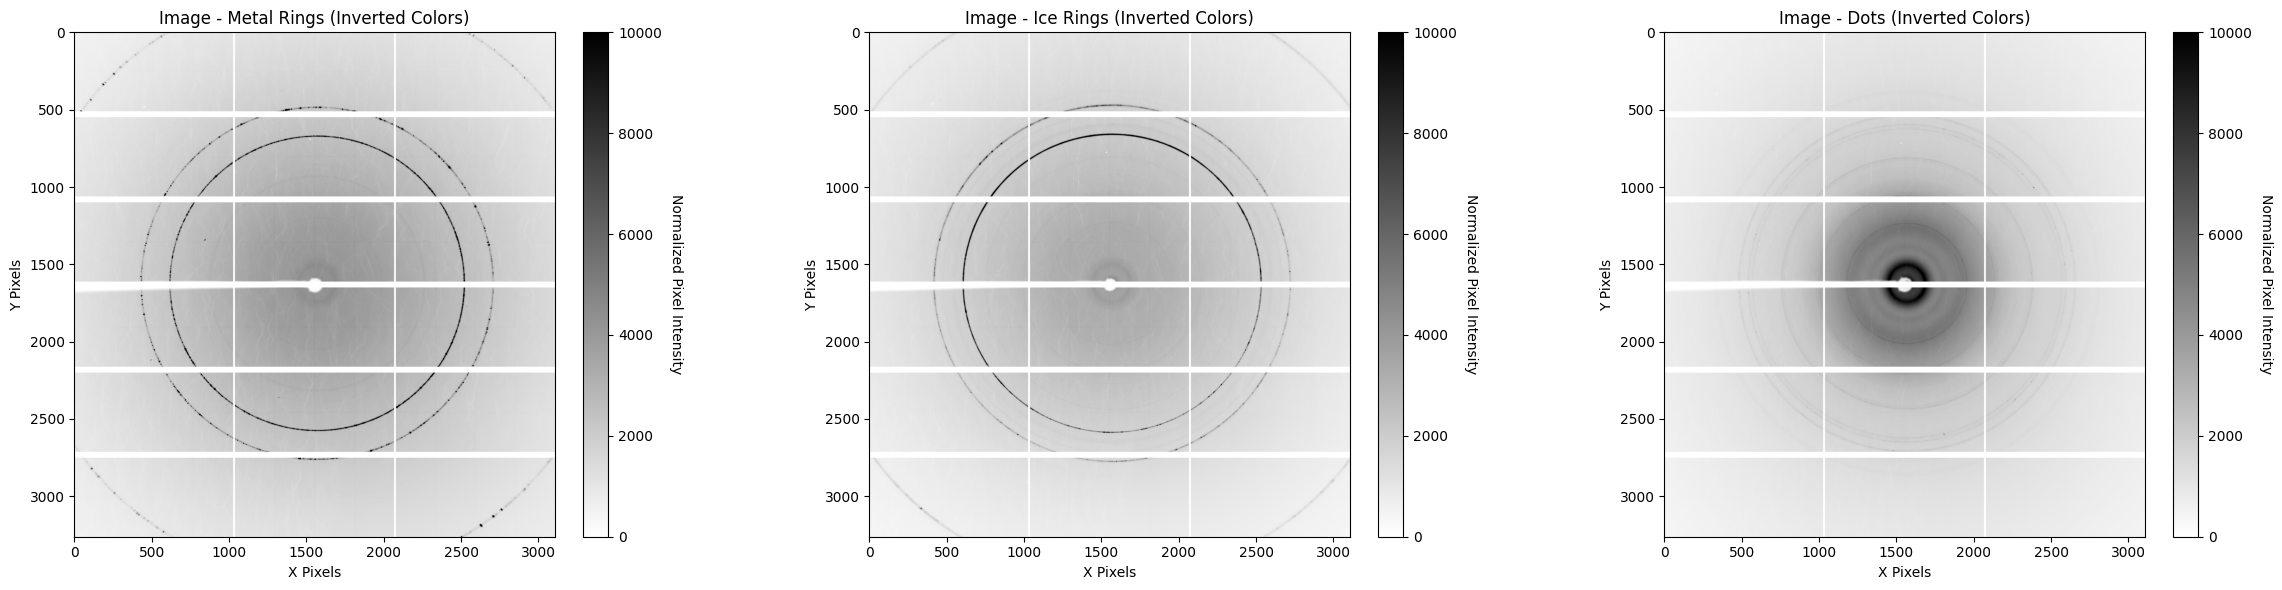

In [ ]:
# clipped_data_metal_rings = np.clip(data_metal_rings, a_min=metal_ring_min_intensity, a_max=100)
# clipped_data_ice_rings = np.clip(data_ice_rings, a_min=ice_ring_min_intensity, a_max=100)
# clipped_data_dots = np.clip(data_dots, a_min=dots_min_intensity, a_max=100)

clipped_data_metal_rings = np.clip(data_metal_rings, a_min=0, a_max=100)
clipped_data_ice_rings = np.clip(data_ice_rings, a_min=0, a_max=100)
clipped_data_dots = np.clip(data_dots, a_min=0, a_max=100)

# Plot the image with inverted color mapping (if needed)
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
images = [clipped_data_metal_rings, clipped_data_ice_rings, clipped_data_dots]
titles = ['Metal Rings', 'Ice Rings', 'Dots']

for ax, img, title in zip(axes, images, titles):
    im = ax.imshow(img, cmap='gray_r', origin='upper')  # 'gray_r' for reversed gray colormap
    ax.set_title(f'Image - {title} (Inverted Colors)')
    ax.set_xlabel('X Pixels')
    ax.set_ylabel('Y Pixels')
    # Create an axis for colorbar to avoid squeezing the main image
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Normalized Pixel Intensity', rotation=270, labelpad=15)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Process image
steps = remove_background_noise_with_steps(data)

# Plot intermediate steps
titles = ['Original (Normalized)', 'Estimated Background',
          'Background Subtracted', 'Contrast Enhanced', 'Adaptive Threshold']
images = [steps['original_normalized'], steps['background'],
          steps['subtracted'], steps['contrast_enhanced'],
          steps['threshold_binary']]

plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

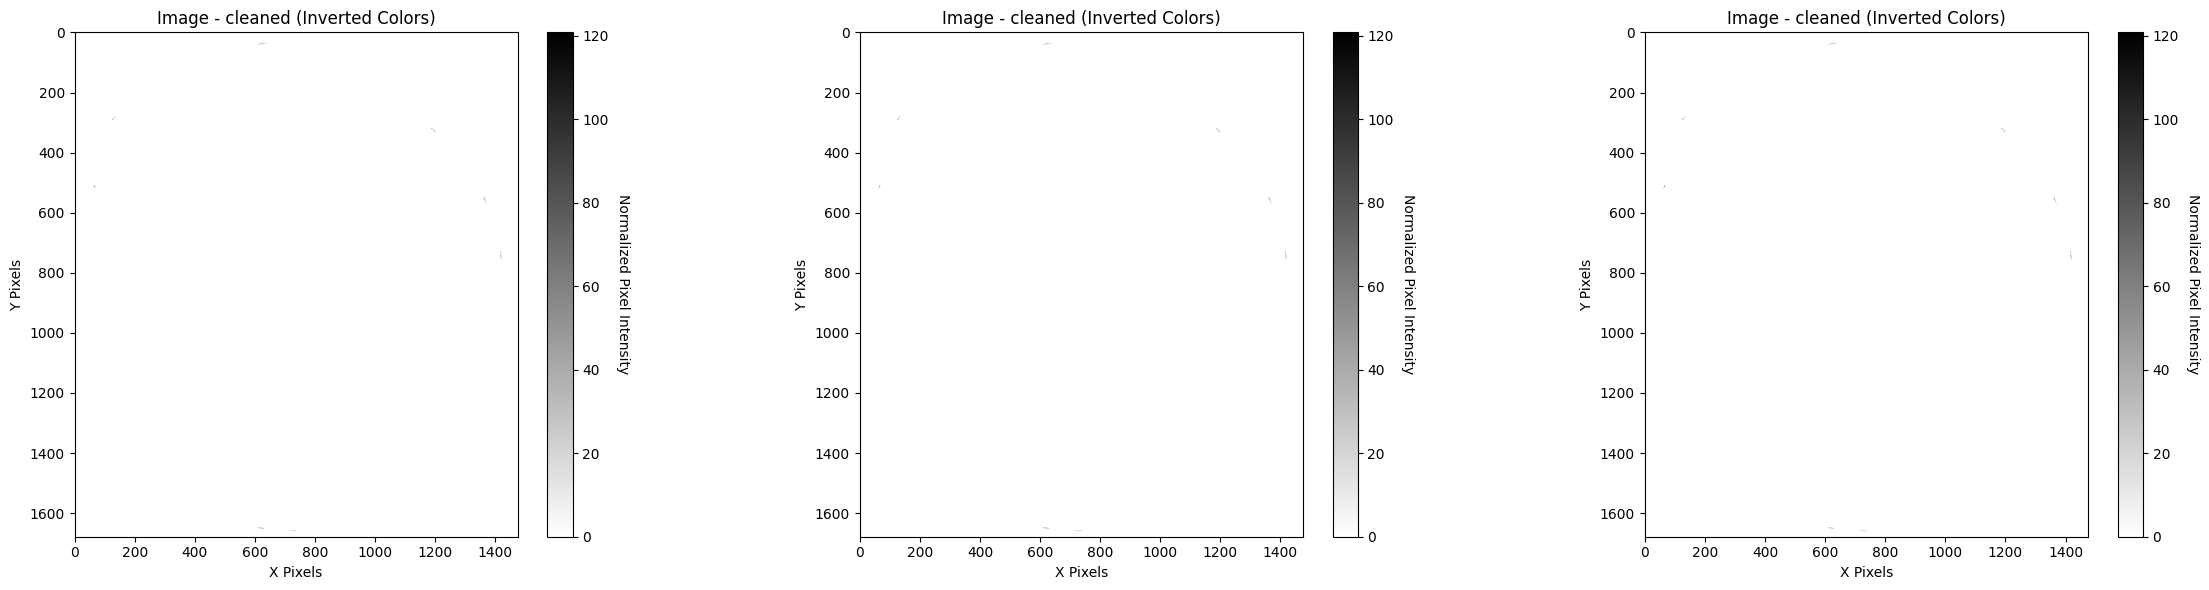

In [ ]:
# Adaptive Thresholding

img = (normalized_data_ice_rings / 60) * 255  # Ensure it's on a 0-255 scale
# final_image = (clipped_data_ice_rings / 100) * 255  # Ensure it's on a 0-255 scale

# Define the center of the image and a mask for the central region
height, width = img.shape
center_x, center_y = width // 2, height // 2
Y, X = np.ogrid[:height, :width]
dist_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
center_radius = min(height, width) # * 0.8
mask_center = dist_from_center <= center_radius

smoothed = gaussian_filter(img, sigma=1)
local_thresh = filters.threshold_local(smoothed, block_size=51, method='gaussian', offset=-10)
binary_local = smoothed > local_thresh
cleaned = morphology.remove_small_objects(binary_local.astype(bool), min_size=50)
final_mask = np.where(mask_center, cleaned, img > filters.threshold_otsu(img))
# final_image = np.where(final_mask, img, 0)
cleaned = np.where(final_mask, img, 0)

# thresh = threshold_otsu(final_image[final_image > 100])
# binary = final_image > thresh
# selem = disk(1) # a defined disk structure with a radius of 2 pixels
# cleaned = opening(binary, selem)

# Plot the image with inverted color mapping (if needed)
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
images = [cleaned, cleaned, cleaned]
titles = ['cleaned', 'cleaned', 'cleaned']

for ax, img, title in zip(axes, images, titles):
    im = ax.imshow(img, cmap='gray_r', origin='upper')  # 'gray_r' for reversed gray colormap
    ax.set_title(f'Image - {title} (Inverted Colors)')
    ax.set_xlabel('X Pixels')
    ax.set_ylabel('Y Pixels')
    # Create an axis for colorbar to avoid squeezing the main image
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Normalized Pixel Intensity', rotation=270, labelpad=15)

# Adjust layout
plt.tight_layout()
plt.show()

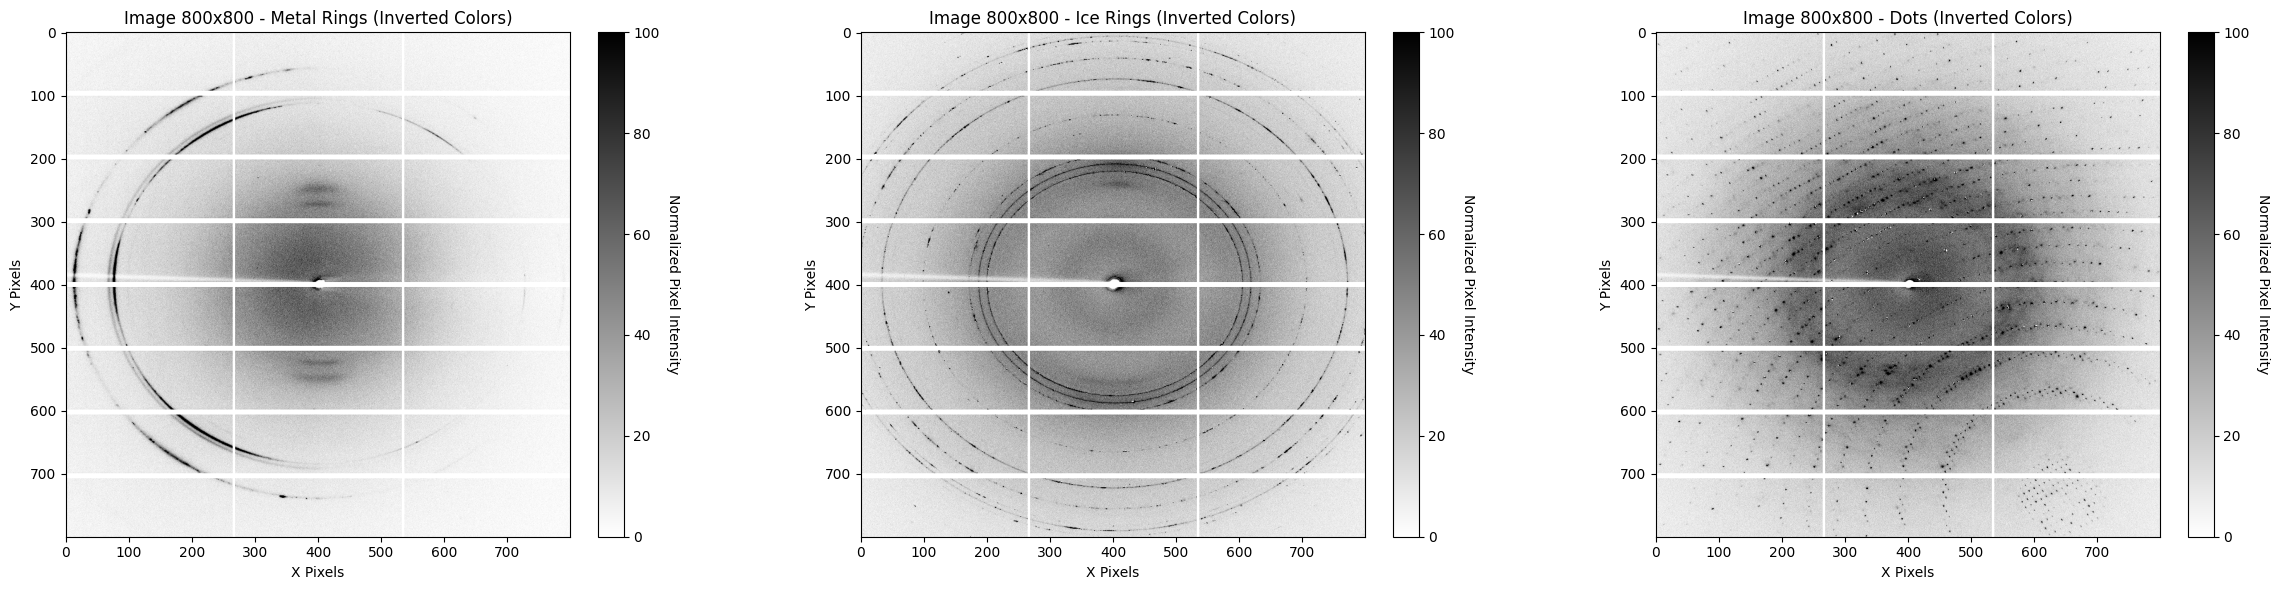

In [ ]:
# clipped_data_metal_rings = np.clip(img_resized_metal_rings, a_min=metal_ring_min_intensity, a_max=100)
# clipped_data_ice_rings = np.clip(img_resized_ice_rings, a_min=ice_ring_min_intensity, a_max=100)
# clipped_data_dots = np.clip(img_resized_dots, a_min=dots_min_intensity, a_max=100)

clipped_data_metal_rings = np.clip(img_resized_metal_rings, a_min=0, a_max=100)
clipped_data_ice_rings = np.clip(img_resized_ice_rings, a_min=0, a_max=100)
clipped_data_dots = np.clip(img_resized_dots, a_min=0, a_max=100)

# Plot the image with inverted color mapping (if needed)
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
images = [clipped_data_metal_rings, clipped_data_ice_rings, clipped_data_dots]
titles = ['Metal Rings', 'Ice Rings', 'Dots']

for ax, img, title in zip(axes, images, titles):
    im = ax.imshow(img, cmap='gray_r', origin='upper')  # 'gray_r' for reversed gray colormap
    ax.set_title(f'Image 800x800 - {title} (Inverted Colors)')
    ax.set_xlabel('X Pixels')
    ax.set_ylabel('Y Pixels')
    # Create an axis for colorbar to avoid squeezing the main image
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Normalized Pixel Intensity', rotation=270, labelpad=15)

# Adjust layout
plt.tight_layout()
plt.show()

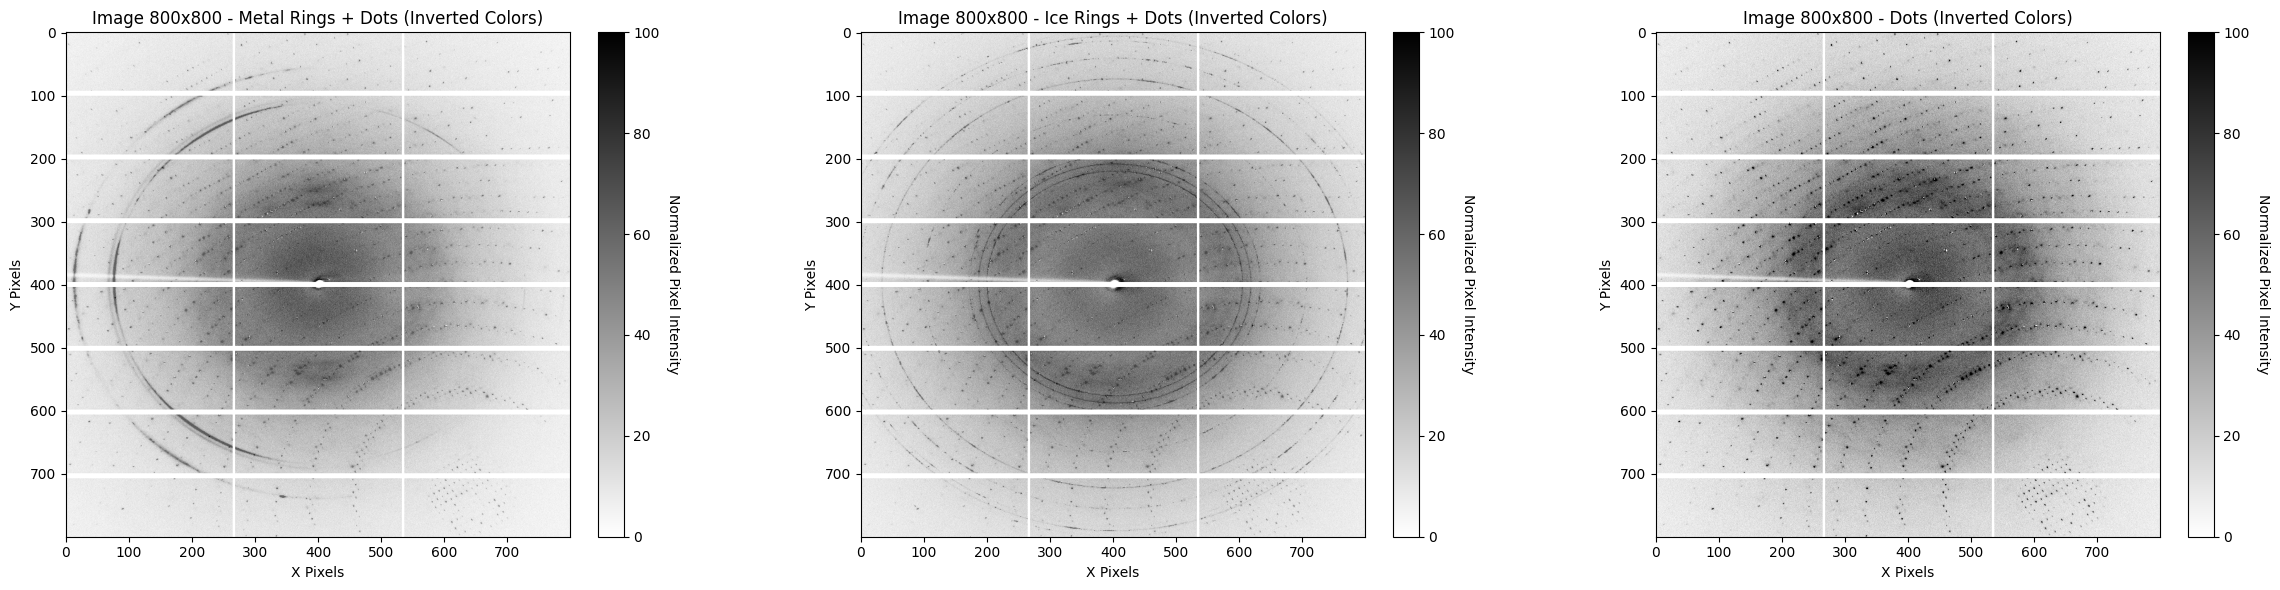

In [ ]:
# Combine images (use averaging or weighted sum)
images_combined_metal_dots = (clipped_data_metal_rings + clipped_data_dots) / 2
images_combined_ice_dots = (clipped_data_ice_rings + clipped_data_dots) / 2

# clipped_data_metal_rings = np.clip(img_resized_metal_rings, a_min=0, a_max=100)
# clipped_data_ice_rings = np.clip(img_resized_ice_rings, a_min=0, a_max=100)
clipped_data_combined_metal_dots = np.clip(images_combined_metal_dots, a_min=0, a_max=100)
clipped_data_combined_ice_dots = np.clip(images_combined_ice_dots, a_min=0, a_max=100)

# Plot the image with inverted color mapping (if needed)
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
images = [clipped_data_combined_metal_dots, clipped_data_combined_ice_dots, clipped_data_dots]
titles = ['Metal Rings + Dots', 'Ice Rings + Dots', 'Dots']

for ax, img, title in zip(axes, images, titles):
    im = ax.imshow(img, cmap='gray_r', origin='upper')  # 'gray_r' for reversed gray colormap
    ax.set_title(f'Image 800x800 - {title} (Inverted Colors)')
    ax.set_xlabel('X Pixels')
    ax.set_ylabel('Y Pixels')
    # Create an axis for colorbar to avoid squeezing the main image
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Normalized Pixel Intensity', rotation=270, labelpad=15)

# Adjust layout
plt.tight_layout()
plt.show()

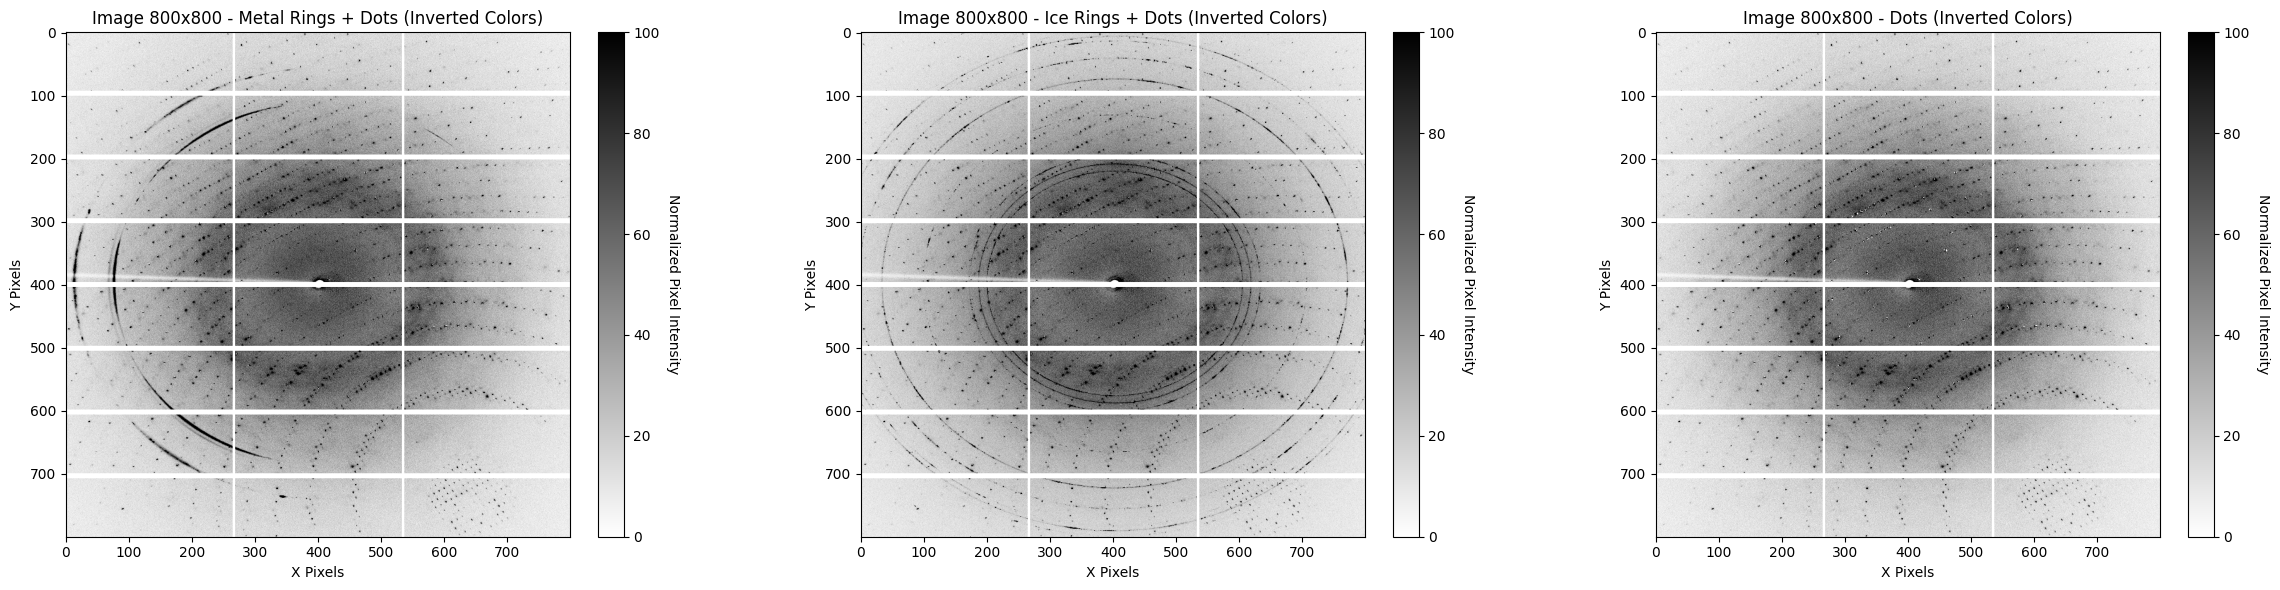

In [ ]:
# Combine images (use max pooling)
images_combined_metal_dots = np.maximum(clipped_data_metal_rings, clipped_data_dots)
images_combined_ice_dots = np.maximum(clipped_data_ice_rings, clipped_data_dots)

# clipped_data_metal_rings = np.clip(img_resized_metal_rings, a_min=0, a_max=100)
# clipped_data_ice_rings = np.clip(img_resized_ice_rings, a_min=0, a_max=100)
clipped_data_combined_metal_dots = np.clip(images_combined_metal_dots, a_min=0, a_max=150)
clipped_data_combined_ice_dots = np.clip(images_combined_ice_dots, a_min=0, a_max=150)

# Plot the image with inverted color mapping (if needed)
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
images = [clipped_data_combined_metal_dots, clipped_data_combined_ice_dots, clipped_data_dots]
titles = ['Metal Rings + Dots', 'Ice Rings + Dots', 'Dots']

for ax, img, title in zip(axes, images, titles):
    im = ax.imshow(img, cmap='gray_r', origin='upper')  # 'gray_r' for reversed gray colormap
    ax.set_title(f'Image 800x800 - {title} (Inverted Colors)')
    ax.set_xlabel('X Pixels')
    ax.set_ylabel('Y Pixels')
    # Create an axis for colorbar to avoid squeezing the main image
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Normalized Pixel Intensity', rotation=270, labelpad=15)

# Adjust layout
plt.tight_layout()
plt.show()

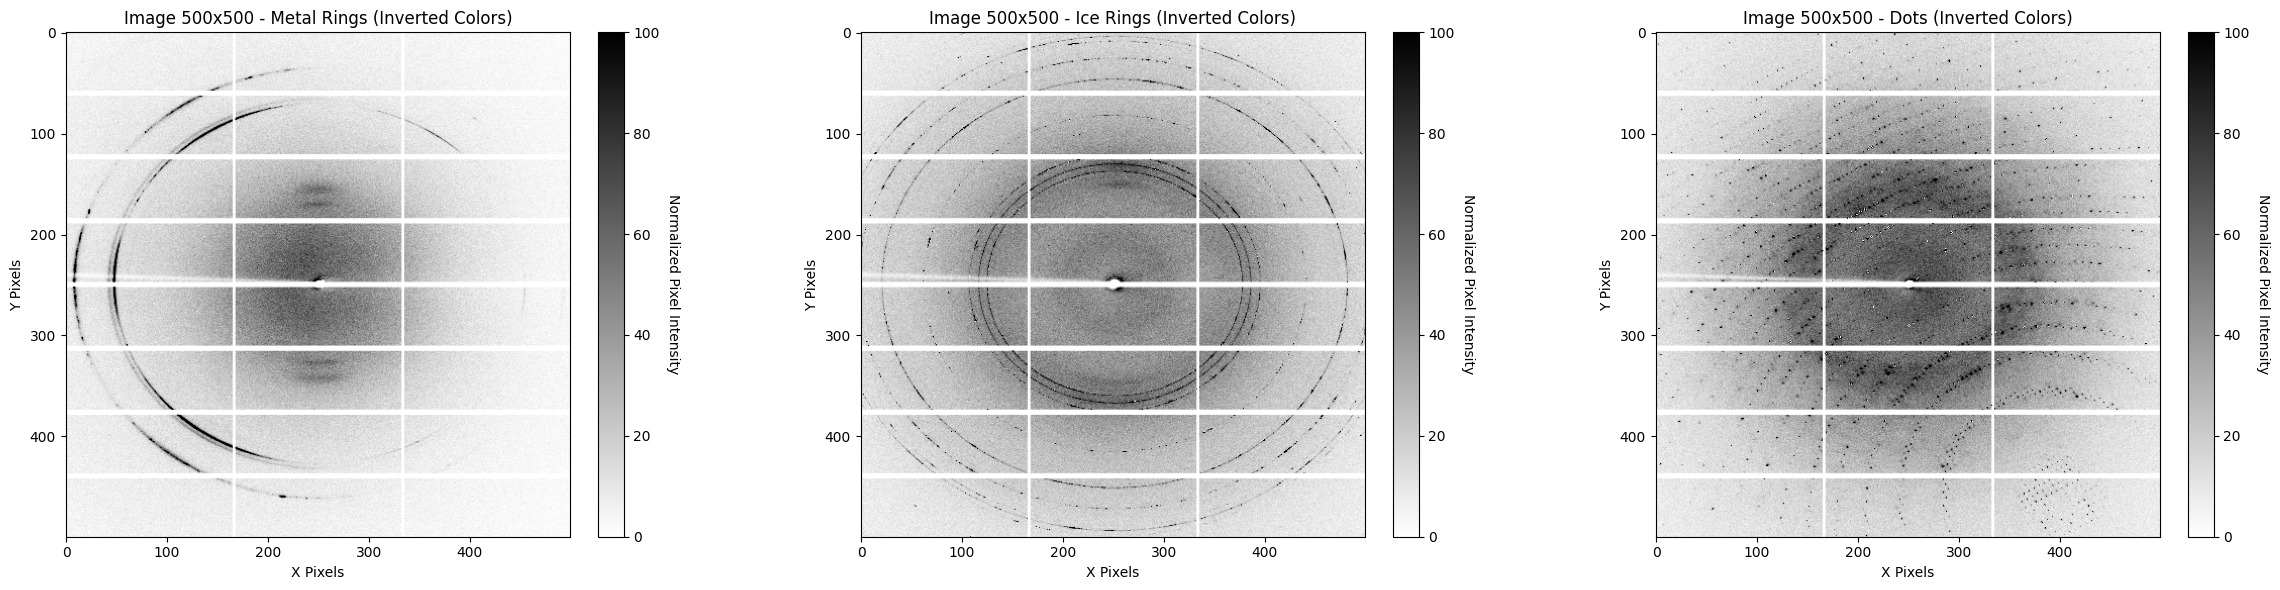

In [ ]:
# 500x500 image visualization
clipped_data_metal_rings = np.clip(img_resized_small_metal_rings, a_min=0, a_max=100)
clipped_data_ice_rings = np.clip(img_resized_small_ice_rings, a_min=0, a_max=100)
clipped_data_dots = np.clip(img_resized_small_dots, a_min=0, a_max=100)

# Plot the image with inverted color mapping (if needed)
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
images = [clipped_data_metal_rings, clipped_data_ice_rings, clipped_data_dots]
titles = ['Metal Rings', 'Ice Rings', 'Dots']

for ax, img, title in zip(axes, images, titles):
    im = ax.imshow(img, cmap='gray_r', origin='upper')  # 'gray_r' for reversed gray colormap
    ax.set_title(f'Image 500x500 - {title} (Inverted Colors)')
    ax.set_xlabel('X Pixels')
    ax.set_ylabel('Y Pixels')
    # Create an axis for colorbar to avoid squeezing the main image
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Normalized Pixel Intensity', rotation=270, labelpad=15)

# Adjust layout
plt.tight_layout()
plt.show()

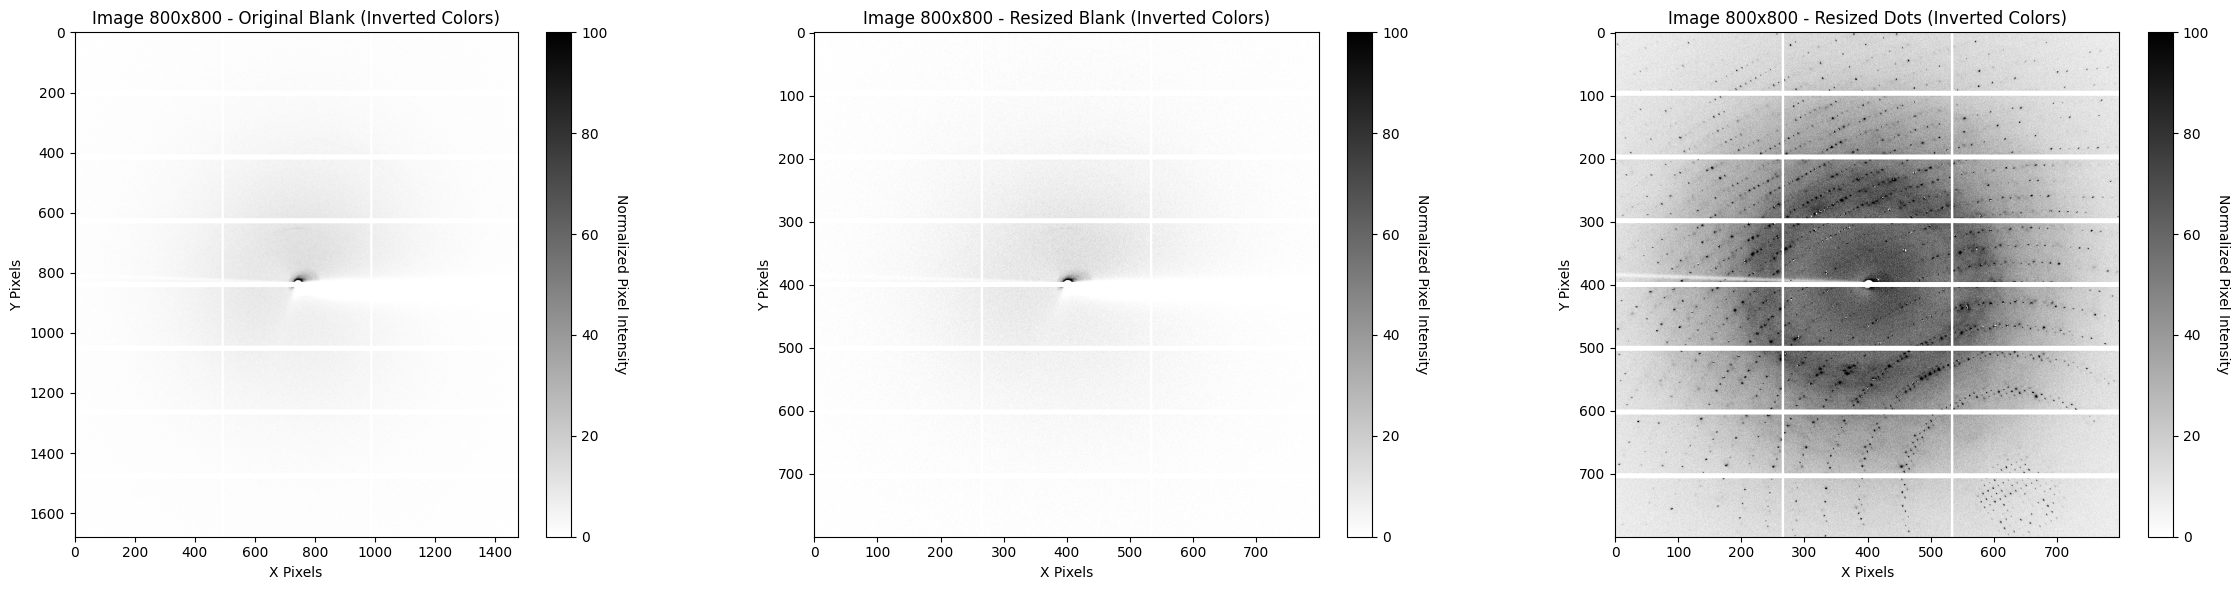

In [ ]:
clipped_data_blank = np.clip(data_blank, a_min=0, a_max=100)
clipped_data_resized_blank = np.clip(img_resized_blank, a_min=0, a_max=100)
clipped_data_dots = np.clip(img_resized_dots, a_min=0, a_max=100)

# Plot the image with inverted color mapping (if needed)
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
images = [clipped_data_blank, clipped_data_resized_blank, clipped_data_dots]
# images = [data_blank, img_resized_blank, clipped_data_dots]
titles = ['Original Blank', 'Resized Blank', 'Resized Dots']

for ax, img, title in zip(axes, images, titles):
    im = ax.imshow(img, cmap='gray_r', origin='upper')  # 'gray_r' for reversed gray colormap
    ax.set_title(f'Image 800x800 - {title} (Inverted Colors)')
    ax.set_xlabel('X Pixels')
    ax.set_ylabel('Y Pixels')
    # Create an axis for colorbar to avoid squeezing the main image
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Normalized Pixel Intensity', rotation=270, labelpad=15)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Apply Local Contrast Normalization in CPU (not the most efficient way)
# selected_images = data_ice_rings[:100]
# normalized_images = np.array([local_contrast_normalization(image) for image in selected_images])
gcn_data_metal_rings = global_contrast_normalization(data_metal_rings)
gcn_data_ice_rings = global_contrast_normalization(data_ice_rings)
gcn_data_dots = global_contrast_normalization(data_dots)

normalized_data_metal_rings = local_contrast_normalization(gcn_data_metal_rings)
normalized_data_ice_rings = local_contrast_normalization(gcn_data_ice_rings)
normalized_data_dots = local_contrast_normalization(gcn_data_dots)

# Plot the image with inverted color mapping (if needed)
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
images = [gcn_data_metal_rings, gcn_data_ice_rings, gcn_data_dots]
titles = ['Metal Rings', 'Ice Rings', 'Dots']

for ax, img, title in zip(axes, images, titles):
    im = ax.imshow(img, cmap='gray_r', origin='upper')  # 'gray_r' for reversed gray colormap
    ax.set_title(f'Image - {title} (Inverted Colors)')
    ax.set_xlabel('X Pixels')
    ax.set_ylabel('Y Pixels')
    # Create an axis for colorbar to avoid squeezing the main image
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Normalized Pixel Intensity', rotation=270, labelpad=15)

# Adjust layout
plt.tight_layout()
plt.show()